In [ ]:
# CPU SIM

In [ ]:
# # Import required packages
# import gymnasium as gym
# import mani_skill.envs
# import time
# env = gym.make("PushCube-v1")
# obs, _ = env.reset(seed=0)
# env.unwrapped.print_sim_details() # print verbose details about the configuration
# done = False
# start_time = time.time()
# while not done:
#     obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
#     done = terminated or truncated
# N = info["elapsed_steps"].item()
# dt = time.time() - start_time
# FPS = N / (dt)
# print(f"Frames Per Second = {N} / {dt} = {FPS}")

In [ ]:
# import matplotlib.pyplot as plt
# env = gym.make("PushCube-v1", render_mode="rgb_array")
# env.reset()
# obs = env.render()[0].numpy()
# plt.imshow(obs) # we take [0].numpy() as everything is a batched tensor
# plt.show()

In [1]:
# GPU SIM (state-only)

In [1]:
print(2+2)

4


In [4]:
### Make sure to restart the notebook if you already ran a CPU sim!! ###
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 1024 # 2048 # you can go up to 4096 on better GPUs
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="state", sim_backend="gpu") # , sim_backend="gpu"
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 1024 parallel environments, sim_backend=gpu
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (1024, 42), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 51200 / 5.629709243774414 = 9094.608226280827


In [5]:
obs.shape

torch.Size([1024, 42])

In [6]:
# GPU SIM (state+visual)

In [7]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 16 # 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgb")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 16 parallel environments, sim_backend=gpu
obs_mode=rgb, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (16, 9), float32), 'qvel': Box(-inf, inf, (16, 9), float32)), 'extra': Dict('is_grasped': Box(False, True, (16,), bool), 'tcp_pose': Box(-inf, inf, (16, 7), float32), 'goal_pos': Box(-inf, inf, (16, 3), float32)), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (16, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (16, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (16, 3, 3), float32))), 'sensor_data': Dict('base_camera': Dict('rgb': Box(0, 255, (16, 128, 128, 3), uint8))))
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 800 / 4.152475357

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['rgb'])
torch.Size([16, 128, 128, 3])


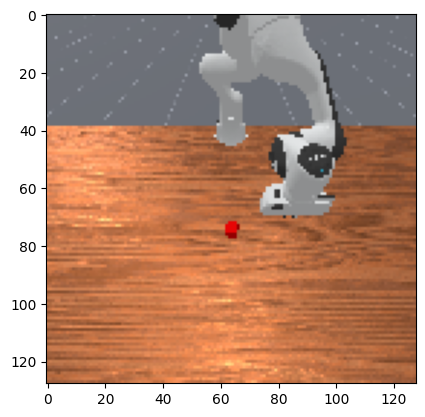

In [8]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
plt.show()

## 1.4 Changing the Environment's Observations and Controllers

In [8]:
# Import required packages
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill.envs
import matplotlib.pyplot as plt

Action Space: Box(-1.0, 1.0, (4, 8), float32)


/home/jovyan/.mlspace/envs/echer-maniskill/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_rgb_array to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_rgb_array` for environment variables or `env.get_wrapper_attr('render_rgb_array')` that will search the reminding wrappers.
  logger.warn(


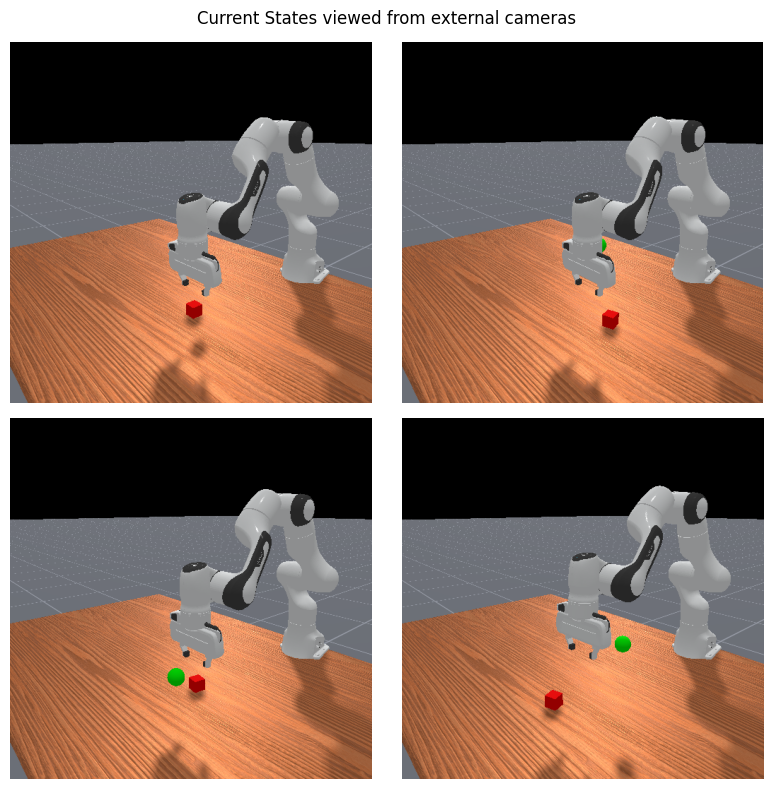

In [9]:
#@markdown Run this cell to display the action space of the chosen controller as well as the current view of the environment
# Can be any env_id from the list of Rigid-Body envs: https://maniskill.readthedocs.io/en/latest/tasks/index.html
env_id = "PickCube-v1" #@param ['PickCube-v1', 'PegInsertionSide-v1', 'StackCube-v1']

# choose an observation type and space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/observation.html for details
obs_mode = "rgb+depth+segmentation" #@param can be one of ['pointcloud', 'rgb+depth+segmentation', 'state_dict', 'state']

# choose a controller type / action space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html for a full list
control_mode = "pd_joint_delta_pos" #@param can be one of ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param can be one of ['sparse', 'dense']

robot_uids = "panda" #@param can be one of ['panda', 'fetch']

# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               num_envs=4,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               robot_uids=robot_uids,
               enable_shadow=True # this makes the default lighting cast shadows
               )
obs, _ = env.reset()
print("Action Space:", env.action_space)

# take a look at the current state of the 4 parallel environments we created
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
rgbs = env.render_rgb_array() # this is a easy way to get the rgb array without having to set render_mode
for i, ax in enumerate(axs.flatten()):
    ax.imshow(rgbs[i].cpu().numpy())
    ax.axis("off")
plt.suptitle("Current States viewed from external cameras")
fig.tight_layout()
env.close()

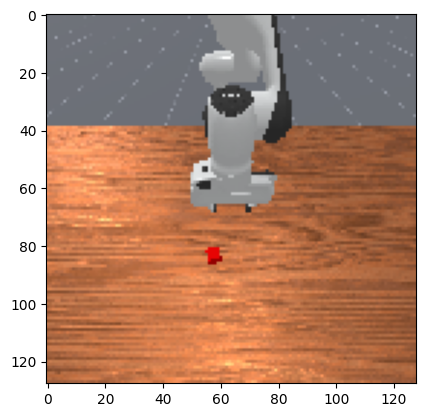

In [11]:
# real observation
plt.imshow(obs['sensor_data']['base_camera']['rgb'][3].cpu().numpy())
plt.show()

In [12]:
# some visualization functions for different observation modes
def show_camera_view(obs_camera, title, env_id=0):
    plt.figure()
    rgb, depth = obs_camera['rgb'], obs_camera['depth']
    plt.subplot(1,3,1)
    plt.title(f"{title} - RGB")
    plt.imshow(rgb[env_id].cpu().numpy())
    plt.subplot(1,3,2)
    plt.title(f"{title} - Depth")
    plt.imshow(depth[..., 0][env_id].cpu().numpy(), cmap="gray")
    plt.subplot(1,3,3)
    plt.title(f"{title} - Segmentation")
    plt.imshow(obs_camera["segmentation"][..., 0][env_id].cpu().numpy())

def show_pointcloud(obs, env_id=0):
    import trimesh
    v = obs['pointcloud']['xyzw'][env_id, ..., :3].cpu().numpy()
    cam2world = obs["sensor_param"]["base_camera"]["cam2world_gl"][env_id].cpu().numpy()
    cam2world = cam2world
    camera = trimesh.scene.Camera("camera", (1024, 1024), fov=(np.rad2deg(np.pi/2), np.rad2deg(np.pi/2)))
    s = trimesh.Scene([trimesh.points.PointCloud(v, obs['pointcloud']['rgb'][env_id].cpu().numpy())], camera=camera, camera_transform=cam2world)
    return s.show()

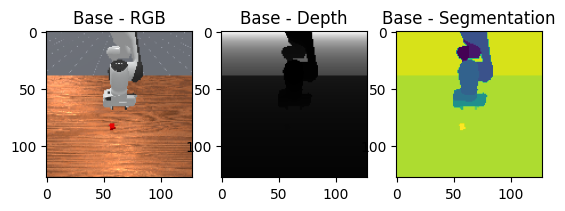

In [13]:
#@markdown Display the RGBD+Segmentation observation. Make sure you are using `obs_mode="rgbd"`
show_camera_view(obs['sensor_data']['base_camera'], "Base", env_id=3)


## 1.5 Interactive Viewer and Recording videos

In [14]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows which make the default lighting cast shadows
env = gym.make("PickCube-v1", num_envs=4, render_mode="rgb_array", 
               enable_shadow=True, obs_mode="rgb+depth+segmentation", reward_mode="dense")

# render_mode="sensors" for real observations (rgb+d) or "rgb_array" for external camera
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2024-12-27 15:08:53,911 - mani_skill  - WARNING - mani_skill is not installed with git.


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

<KeysViewHDF5 ['traj_0', 'traj_1', 'traj_2', 'traj_3']>
<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states', 'rewards']>
actions (100, 8)
obs (101, 128, 128, 3)
terminated (100,)
truncated (100,)
success (100,)
rewards (100,)


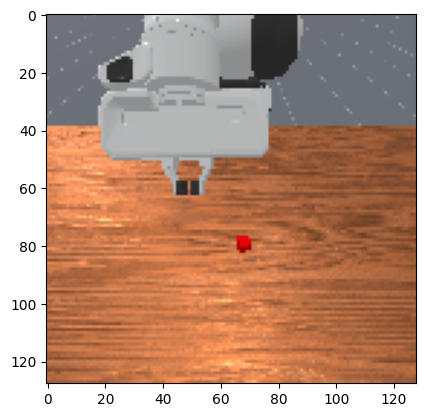

In [8]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("./videos/20241029_210236.h5", "r") as f:
    # Print available trajectories
    print(f.keys())
    traj = f["traj_3"]
    print(traj.keys())
    print("actions", traj["actions"].shape)
    print("obs", traj["obs"]['sensor_data']['base_camera']['rgb'][()].shape)
    print('terminated', traj["terminated"][()].shape)
    print('truncated', traj["truncated"][()].shape)
    print('success', traj["success"][()].shape)
    print('rewards', traj["rewards"][()].shape)
    plt.imshow(traj["obs"]['sensor_data']['base_camera']['rgb'][()][-1]) # -1 -- last frame
    plt.show()


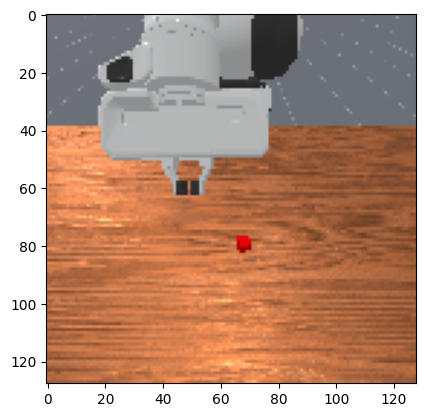

In [7]:
plt.imshow(obs['sensor_data']['base_camera']['rgb'][3].cpu().numpy())
plt.show()

# Test

In [11]:
import ppo

In [17]:
# state
# python ppo.py --env_id="PushCube-v1" --exp-name="state-pushcube" --num_envs=1024 --update_epochs=8 --num_minibatches=32 --total_timesteps=600_000 --eval_freq=8 --num-steps=20 --track --capture-video --save-model

# visual
# ppo_rgb.py --env_id=PushCube-v1 --exp-name=rgb-pushcube --num_envs=256 --update_epochs=8 --num_minibatches=8 --total_timesteps=1_000_000 --eval_freq=10 --num-steps=20 --track --capture-video --save-model
# python ManiSkill/ppo_rgb_thimble.py --env_id=Thimble-v1 --exp-name=rgb-thimble --num_envs=256 --update_epochs=8 --num_minibatches=8 --total_timesteps=1_000_000 --eval_freq=10 --num-steps=20 --capture-video --save-model --wandb-project-name "Maniskill-Thimble" --track

In [23]:
Video("./runs/rgb-pushcube/videos/17.mp4", embed=True, width=1024) # Watch a replay during training evaluation

In [ ]:
!python ppo_rgb.py --env_id="PushCube-v1" \
  --evaluate --checkpoint=runs/rgb-pushcube/ckpt_171.pt \
  --num_eval_envs=10 --num-eval-steps=100

<KeysViewHDF5 ['traj_0', 'traj_1', 'traj_10', 'traj_11', 'traj_12', 'traj_13', 'traj_14', 'traj_15', 'traj_16', 'traj_17', 'traj_18', 'traj_19', 'traj_2', 'traj_3', 'traj_4', 'traj_5', 'traj_6', 'traj_7', 'traj_8', 'traj_9']>
<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states', 'rewards']>
actions (50, 8)
obs (51, 128, 128, 3)
terminated (50,)
truncated (50,)
success (50,)
rewards [0.11232214 0.14459273 0.17059812 0.19023483 0.21046905 0.23571056
 0.26072186 0.28401464 0.29934317 0.30935088 0.42326033 0.44115338
 0.45491886 0.31564945 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


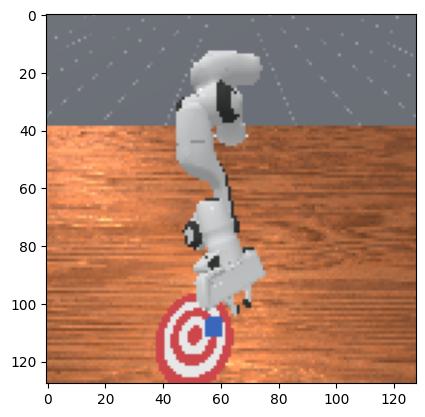

In [71]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("./runs/rgb-pushcube/test_videos/trajectory.h5", "r") as f:
    # Print available trajectories
    print(f.keys())
    traj = f["traj_0"]
    print(traj.keys())
    print("actions", traj["actions"].shape)
    print("obs", traj["obs"]["rgb"][()].shape)
    print('terminated', traj["terminated"][()].shape)
    print('truncated', traj["truncated"][()].shape)
    print('success', traj["success"][()].shape)
    print('rewards', traj["rewards"][()])
    plt.imshow(traj["obs"]["rgb"][()][-1]) # -1 -- last frame
    plt.show()


# Load checkpoint

In [ ]:
import torch
import gymnasium as gym
from ppo_rgb import Agent, Args
import mani_skill.envs
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from tqdm.notebook import tqdm

args = Args()
args.env_id = "PushCube-v1"
args.render_mode = "all"
args.include_state = True  # Enable state features since checkpoint uses them
args.num_envs = 256
args.update_epochs = 8
args.num_minibatches = 8
args.total_timesteps = 1_000_000
args.eval_freq = 10
args.num_steps = 20
args.evaluate = True
args.num_eval_envs = 8
args.cuda = True
args.num_eval_steps = 100
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# Load checkpoint
checkpoint_path = "./runs/rgb-pushcube/ckpt_171.pt"
checkpoint = torch.load(checkpoint_path)
# eval_output_dir = "./runs/rgb-pushcube/test_videos/"
eval_output_dir = "./eval_videos"
# Create environment and agent
env_kwargs = dict(obs_mode="rgb", control_mode="pd_joint_delta_pos", render_mode=args.render_mode, sim_backend="gpu")
eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs) # , reconfigure_freq=args.eval_reconfiguration_freq
eval_envs = FlattenRGBDObservationWrapper(eval_envs, rgb=True, depth=False, state=args.include_state)
eval_envs = RecordEpisode(eval_envs, output_dir=eval_output_dir, save_trajectory=args.evaluate, trajectory_name="trajectory_v3", max_steps_per_video=args.num_eval_steps, video_fps=30)
eval_envs = ManiSkillVectorEnv(eval_envs, args.num_eval_envs, ignore_terminations=True, record_metrics=True)

# print(agent)

# Load state dict
eval_obs, _ = eval_envs.reset()
print(eval_obs.keys())

agent = Agent(eval_envs, sample_obs=eval_obs).to(device)
agent.load_state_dict(checkpoint)
print(f"Loaded checkpoint from {checkpoint_path}")

# Validate by running one episode
obs, _ = eval_envs.reset()
obs = {k: v.to(device).float() for k, v in obs.items()}
done = False
total_reward = 0

for _ in tqdm(range(100)):
    action = agent.get_action(obs).to(device)
    obs, reward, terminated, truncated, info = eval_envs.step(action)
    total_reward += reward
    done = torch.logical_or(terminated, truncated).to(torch.float32)

eval_envs.close()

from IPython.display import Video
Video("./eval_videos/0.mp4", embed=True, width=640) # Watch our replay

In [3]:
eval_envs.action_space

Box(-1.0, 1.0, (8, 8), float32)

<KeysViewHDF5 ['traj_0', 'traj_1', 'traj_10', 'traj_11', 'traj_12', 'traj_13', 'traj_14', 'traj_15', 'traj_2', 'traj_3', 'traj_4', 'traj_5', 'traj_6', 'traj_7', 'traj_8', 'traj_9']>
<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states', 'rewards']>
actions (50, 8)
obs (51, 128, 128, 3)
terminated (50,)
truncated (50,)
done [False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False  True]
success (50,)
rewards (50,)


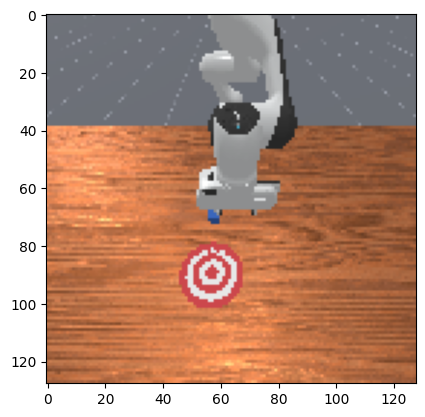

In [30]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("./eval_videos/trajectory_v3.h5", "r") as f:
    # Print available trajectories
    print(f.keys())
    traj = f["traj_0"]
    print(traj.keys())
    print("actions", traj["actions"].shape)
    print("obs", traj["obs"]["rgb"][()].shape)
    print('terminated', traj["terminated"][()].shape)
    print('truncated', traj["truncated"][()].shape)
    print('done', np.logical_or(traj["terminated"][()], traj["truncated"][()]))

    print('success', traj["success"][()].shape)
    
    print('rewards', traj["rewards"][()].shape)
    plt.imshow(traj["obs"]["rgb"][()][0]) # -1 -- last frame
    plt.show()

# Dataset creation

In [ ]:
import torch
import gymnasium as gym
from ppo_rgb import Agent, Args
import mani_skill.envs
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from tqdm.notebook import tqdm

import h5py
import matplotlib.pyplot as plt
import numpy as np

args = Args()
args.env_id = "PushCube-v1"
args.render_mode = "all"
args.include_state = True  # Enable state features since checkpoint uses them
args.num_envs = 256
args.update_epochs = 8
args.num_minibatches = 8
args.total_timesteps = 1_000_000
args.eval_freq = 10
args.num_steps = 20
args.evaluate = True
args.num_eval_envs = 8
args.cuda = True
args.num_eval_steps = 100
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# Load checkpoint
checkpoint_path = "./runs/rgb-pushcube/ckpt_171.pt"
checkpoint = torch.load(checkpoint_path)
# eval_output_dir = "./runs/rgb-pushcube/test_videos/"
eval_output_dir = "./dataset_pushcube_v1"
env_kwargs = dict(obs_mode="rgb", control_mode="pd_joint_delta_pos", render_mode=args.render_mode, sim_backend="gpu")

In [ ]:
num_envs = 512 # 512 * 8 = 4096

for trajectory in tqdm(range(434,num_envs)):

    eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs)
    eval_envs = FlattenRGBDObservationWrapper(eval_envs, rgb=True, depth=False, state=args.include_state)
    eval_envs = RecordEpisode(eval_envs, output_dir=eval_output_dir, save_trajectory=args.evaluate, 
                              trajectory_name=f"trajectory_{trajectory}", max_steps_per_video=args.num_eval_steps, video_fps=30)
    eval_envs = ManiSkillVectorEnv(eval_envs, args.num_eval_envs, ignore_terminations=True, record_metrics=True)

    eval_obs, _ = eval_envs.reset()

    agent = Agent(eval_envs, sample_obs=eval_obs).to(device)
    agent.load_state_dict(checkpoint)

    # Validate by running one episode
    obs, _ = eval_envs.reset()
    obs = {k: v.to(device).float() for k, v in obs.items()}

    for _ in range(100):
        action = agent.get_action(obs).to(device)
        obs, reward, terminated, truncated, info = eval_envs.step(action)
        done = torch.logical_or(terminated, truncated).to(torch.float32)

    eval_envs.close()

## Read data

<KeysViewHDF5 ['traj_0', 'traj_1', 'traj_10', 'traj_11', 'traj_12', 'traj_13', 'traj_14', 'traj_15', 'traj_2', 'traj_3', 'traj_4', 'traj_5', 'traj_6', 'traj_7', 'traj_8', 'traj_9']>
<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states', 'rewards']>
actions (50, 8)
obs (51, 128, 128, 3)
done (50,)
success (50,)
rewards (50,)


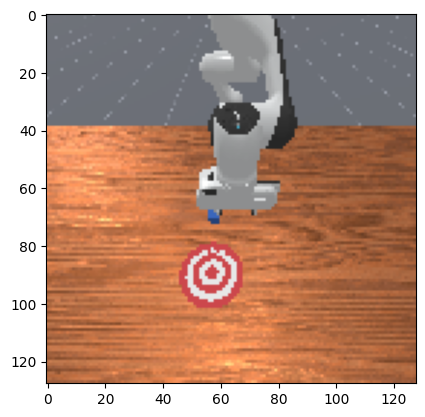

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("./dataset_pushcube_v1/trajectory_135.h5", "r") as f:
    # Print available trajectories
    print(f.keys())
    traj = f["traj_0"]
    print(traj.keys())
    print("actions", traj["actions"].shape)
    print("obs", traj["obs"]["rgb"][()].shape)
    print('done', np.logical_or(traj["terminated"][()], traj["truncated"][()]).shape)

    print('success', traj["success"][()].shape)
    
    print('rewards', traj["rewards"][()].shape)
    plt.imshow(traj["obs"]["rgb"][()][0]) # -1 -- last frame
    plt.show()

In [4]:
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm

class ManiSkillIterDataset(Dataset):
    def __init__(self, directory, gamma, max_length, normalize):
        """_summary_

        Args:
            directory (str): path to the directory with data files
            gamma (float): discount factor
            max_length (int): maximum number of timesteps used in batch generation
                                (max in dataset: 1001)
        """
        
        self.global_ind = 0
        self.directory = directory
        self.file_list = os.listdir(directory)
        print(self.file_list)
        self.gamma = gamma
        self.max_length = max_length
        self.normalize = normalize
        self.filtered_list = []
        print('Filtering data...')
        self.filter_trajectories()
        print("Filtering complete. Number of .h5 files: ", len(self.filtered_list))

        self.list_of_trajectories = []
        self.decouple_h5_files()

    def discount_cumsum(self, x):
        """
        Compute the discount cumulative sum of a 1D array.

        Args:
            x (ndarray): 1D array of values.

        Returns:
            ndarray: Discount cumulative sum of the input array.
        """
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + self.gamma * discount_cumsum[t+1]
        return discount_cumsum

    def filter_trajectories(self):
        """
        Select only .h5 files with trajectories (each file consists of multiple trajectories)
        """
        for idx in tqdm(range(len(self.file_list))):
            if self.file_list[idx].endswith('.h5'):
                self.filtered_list.append(self.file_list[idx])

    def decouple_h5_files(self):
        # Create a folder at the same level as self.directory if it doesn't exist
        parent_dir = os.path.dirname(os.path.dirname(self.directory))
        new_folder = os.path.join(parent_dir, os.path.basename(self.directory.rstrip('/')) + "_" + "single_h5/")
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)

        for file_path in tqdm(self.filtered_list):
            with h5py.File(self.directory+file_path, "r") as f:
                for i in range(len(f.keys())):
                    traj = f[f"traj_{i}"]
                    a = traj["actions"][()]
                    o = traj["obs"]["rgb"][()]
                    d = np.logical_or(traj["terminated"][()], traj["truncated"][()])
                    r = traj["rewards"][()]
                    # print(file_path)
                    path = new_folder+"trajectory"+"_"+str(self.global_ind)+".npz"
                    self.list_of_trajectories.append(path)
                    np.savez(path, a=a, o=o, d=d, r=r)
                    self.global_ind += 1

            if self.global_ind >= 128: # ! delete in after debugging
                break

    def __len__(self):
        return len(self.list_of_trajectories)

    def __getitem__(self, idx):
        """
        obs: (T, H, W, C) -> (T, C, H, W)
        """
        file_path = os.path.join(self.list_of_trajectories[idx])
        data = np.load(file_path)

        s = data['o']
        a = data['a']
        r = data['r']
        d = data['d']

        s = torch.from_numpy(s).float().permute(0, 3, 1, 2)

        if self.normalize == 1:
            s = s / 255.0
        
        s = s.unsqueeze(0)

        a = torch.from_numpy(a).unsqueeze(0).unsqueeze(-1)
        print(np.max(r))
        rtg = torch.from_numpy(self.discount_cumsum(r)).unsqueeze(0).unsqueeze(-1)
        d = torch.from_numpy(d).unsqueeze(0).unsqueeze(-1).to(dtype=torch.long)
       
        timesteps = torch.from_numpy(np.arange(0, self.max_length).reshape(1, -1, 1))
        mask = torch.ones_like(a)
        
        # * from beginning of trajectory
        s = s[:, :self.max_length, :, :, :]
        a = a[:, :self.max_length, :]
        rtg = rtg[:, :self.max_length, :]
        d = d[:, :self.max_length, :]
        mask = mask[:, :self.max_length, :]
        return s.squeeze(0), a.squeeze(0), rtg.squeeze(0), d.squeeze(), timesteps.squeeze(), mask.squeeze()

dataset = ManiSkillIterDataset("./dataset_pushcube_v1/", gamma=1.0, max_length=50, normalize=1)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

['trajectory_301.json', 'trajectory_84.json', 'trajectory_62.json', 'trajectory_401.json', 'trajectory_132.h5', 'trajectory_327.h5', 'trajectory_377.h5', 'trajectory_106.h5', 'trajectory_174.json', 'trajectory_205.json', 'trajectory_246.h5', 'trajectory_309.h5', 'trajectory_279.h5', 'trajectory_236.h5', 'trajectory_432.h5', 'trajectory_125.json', 'trajectory_343.json', 'trajectory_410.json', 'trajectory_451.json', 'trajectory_351.h5', 'trajectory_468.json', 'trajectory_276.json', 'trajectory_98.h5', 'trajectory_218.h5', 'trajectory_253.h5', 'trajectory_487.json', 'trajectory_290.h5', 'trajectory_293.json', 'trajectory_124.h5', 'trajectory_4.json', 'trajectory_9.json', 'trajectory_217.h5', 'trajectory_435.json', 'trajectory_511.h5', 'trajectory_451.h5', 'trajectory_137.h5', 'trajectory_13.json', 'trajectory_211.json', 'trajectory_449.h5', 'trajectory_255.json', 'trajectory_23.h5', 'trajectory_57.h5', 'trajectory_47.h5', 'trajectory_249.h5', 'trajectory_101.h5', 'trajectory_129.json', 't

100%|██████████| 1025/1025 [00:00<00:00, 1278370.98it/s]


Filtering complete. Number of .h5 files:  512


  1%|▏         | 7/512 [00:04<04:52,  1.73it/s]


In [4]:
s, a, rtg, d, timesteps, masks = next(iter(dataloader))
print(s.shape, a.shape, rtg.shape, d.shape, timesteps.shape, masks.shape)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.4333939
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.30694947
1.0
1.0
1.0
1.0
1.0
0.31542578
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
torch.Size([128, 50, 3, 128, 128]) torch.Size([128, 50, 8, 1]) torch.Size([128, 50, 1]) torch.Size([128, 50]) torch.Size([128, 50]) torch.Size([128, 50, 8])


# Test RATE

In [1]:
import sys
import torch
sys.path.append('../')
import yaml
from collections import defaultdict
from RATE import mem_transformer_v2_GTrXL

import torch
import gymnasium as gym
from ppo_rgb import Agent, Args
import mani_skill.envs
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from tqdm.notebook import tqdm

with open("../ManiSkill/ManiSkill_src/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
config["model_mode"] = "RATE"
config["text_description"] = "RATE_K16_N3_nmt5_ml174_nhca2_relu"

model = mem_transformer_v2_GTrXL.MemTransformerLM(**config["model_config"])
model.load_state_dict(torch.load("../ManiSkill/ManiSkill_checkpoints/RATE_K16_N3_nmt5_ml174_nhca2_relu/RATE_K16_N3_nmt5_ml174_nhca2_relu_arch_mode_TrXL_RATE_RUN_2_2024_11_06_18_52_14/17388980_KTD.pth", map_location=device))
model.to(device)

In [126]:
import torch
import numpy as np

from TMaze_new.TMaze_new_src.utils import set_seed
from collections import defaultdict
from typing import Optional, Tuple, List, Dict, Any

import torch
import gymnasium as gym
from ppo_rgb import Agent, Args
import mani_skill.envs
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from tqdm.notebook import tqdm

@torch.no_grad()
def sample(
    model: torch.nn.Module,
    x: torch.Tensor,
    block_size: int,
    steps: int = 1,
    sample: bool = False,
    actions: Optional[torch.Tensor] = None,
    rtgs: Optional[torch.Tensor] = None,
    timestep: Optional[torch.Tensor] = None,
    mem_tokens: Optional[torch.Tensor] = None,
    saved_context: Optional[List] = None
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[List], Any]:
    """Sample actions from the model.
    
    Args:
        model: The transformer model
        x: Input states tensor
        block_size: Maximum sequence length
        steps: Number of sampling steps
        sample: Whether to sample or take argmax
        actions: Previous actions tensor
        rtgs: Returns-to-go tensor  
        timestep: Current timestep tensor
        mem_tokens: Memory tokens
        saved_context: Saved context from previous forward pass
    
    Returns:
        Tuple of (logits, new_mem_tokens, new_context, attention_map)
    """
    model.eval()
    
    # Crop sequences if needed
    x_cond = x if x.size(1) <= block_size else x[:, -block_size:]
    if actions is not None:
        actions = actions if actions.size(1) <= block_size else actions[:, -block_size:]
    rtgs = rtgs if rtgs.size(1) <= block_size else rtgs[:, -block_size:]

    # Forward pass
    if saved_context is not None:
        results = model(x_cond, actions, rtgs, None, timestep, *saved_context, mem_tokens=mem_tokens)
    else:
        results = model(x_cond, actions, rtgs, None, timestep, mem_tokens=mem_tokens)

    return (
        results[0][0].detach()[:,-1,:],  # logits
        results[1],                       # mem_tokens
        results[0][2:],                   # memory
        model.attn_map                    # attention map
    )

def get_returns_ManiSkill(env, model, ret, seed, episode_timeout, context_length, device, act_dim, config, mean, std, use_argmax=False, create_video=False):
    # env = None
    # device = torch.device("cpu")
    model.to(device)

    set_seed(seed)

    # eval_output_dir = f"ManiSkill/val_videos/{config['model_mode']}/{config['text_description']}"
    # env_kwargs = dict(obs_mode="rgb", control_mode="pd_joint_delta_pos", render_mode="all", sim_backend="cpu")

    # env = gym.make("PushCube-v1", num_envs=1, **env_kwargs) 
    # env = FlattenRGBDObservationWrapper(env, rgb=True, depth=False, state=True)
    # if isinstance(env.action_space, gym.spaces.Dict):
    #     env = FlattenActionSpaceWrapper(env) 
    # env = RecordEpisode(env, output_dir=eval_output_dir, save_trajectory=False, trajectory_name=f"rate_val", max_steps_per_video=50, video_fps=30)
    # env = ManiSkillVectorEnv(env, 1, ignore_terminations=True, record_metrics=True)

    scale = 1
    
    # Reset environment and get initial state
    state_0, _ = env.reset(seed=seed)
    state_0 = state_0['rgb'][0]
    
    # Convert state to expected format [C, H, W] and add batch/sequence dimensions
    state = state_0.float().permute(2, 0, 1).to(device)  # [C, H, W]
    state = state.unsqueeze(0).unsqueeze(0)   # [1, 1, C, H, W]
    
    # Initialize episode tracking
    episode_return = 0
    episode_length = 0
    done = False
    HISTORY_LEN = context_length
    
    # Initialize state/action tracking
    states = state.to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    
    # Initialize return targets and timesteps
    target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    
    # Initialize memory tracking
    mem_tokens = (model.mem_tokens.repeat(1, 1, 1).detach() 
                    if model.mem_tokens is not None else None)
    saved_context = None
    segment = 0
    prompt_steps = 0
    
    # Initialize output tracking
    out_states = [state.cpu().numpy()]
    frames, rews, act_list, memories, eval_metrics = [env.render()], [], [], [], defaultdict(list)
    
    for t in range(episode_timeout):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])
        
        # RATE / RMT / TrXL
        if config["model_mode"] not in ['DT', 'DTXL']:
            # For non-DT models, truncate sequences when they exceed history length
            if actions.shape[0] > HISTORY_LEN:
                segment += 1

                keep_steps = prompt_steps if prompt_steps > 0 else 1

                actions = actions[-keep_steps:, :]
                states = states[:, -keep_steps:, :, :, :]
                target_return = target_return[:, -keep_steps:]
                timesteps = timesteps[:, -keep_steps:]
                
                # Update memory tokens periodically
                if t % context_length == 0 and t > 5:
                    mem_tokens = new_mem
                    saved_context = new_notes
                    
                    if create_video:
                        memory_norm = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {memory_norm}')
                        
        # DT / DTXL          
        else:
            if actions.shape[0] > HISTORY_LEN:
                segment += 1
                
                keep_steps = prompt_steps if prompt_steps > 0 else 1

                actions = actions[-keep_steps:, :]
                states = states[:, -keep_steps:, :, :, :]
                target_return = target_return[:, -keep_steps:]
                timesteps = timesteps[:, -keep_steps:]
                    
                # Update memory tokens periodically
                if t % context_length == 0 and t > 5:
                    if create_video:
                        memory_norm = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {memory_norm}')
                    mem_tokens = new_mem
                    saved_context = new_notes

        if t==0:
            act_to_pass = None
        else:
            act_to_pass = actions.unsqueeze(0)[:, 1:, :]
            if act_to_pass.shape[1] == 0:
                act_to_pass = None 
        
        # !!!!!!!!!!!!!!!!!!!!!!!!!
        if config["data_config"]["normalize"] == 2:
            b, l, c, h, w = states.shape
            states_norm = states.reshape(b*l, c, h, w)
            states_norm = z_normalize(states_norm, mean.to(device), std.to(device))
            states_norm = states_norm.reshape(b, l, c, h, w).to(device)
        elif config["data_config"]["normalize"] == 1:
            states_norm = states / 255.0
        elif config["data_config"]["normalize"] == 0:
            states_norm = states

        # !!!!!!!!!!!!!!!!!!!
        # print(states_norm.device, act_to_pass.device if act_to_pass is not None else None, timesteps.device)
        try:
            sampled_action, new_mem, new_notes, attn_map = sample(
                model=model,
                x=states_norm,
                block_size=HISTORY_LEN,
                steps=1,
                sample=True,
                actions=act_to_pass,
                rtgs=target_return.unsqueeze(-1),
                timestep=timesteps,
                mem_tokens=mem_tokens,
                saved_context=saved_context
            )
        except Exception as e:
            print(f"Error during sampling at timestep {t}:")
            print(f"states shape: {states.shape}")
            print(f"target_return shape: {target_return.shape}") 
            print(f"actions shape: {act_to_pass.shape if act_to_pass is not None else None}")
            print(f"Exception: {str(e)}")
            raise
            
        if new_mem is not None:
            memories.append(mem_tokens.detach().cpu().numpy())

        act = sampled_action#.detach().cpu().numpy()
        
        actions[-1, :] = act
        act_list.append(act)
        # print(act.device)
        state, reward, terminated, truncated, eval_infos = env.step(act) # state [H, W, C], need [C, H, W]
        print(t, reward, reward.item(), (reward==1).to(torch.float32))
        # print(reward.device, terminated.device, truncated.device)
        done = torch.logical_or(terminated, truncated).item()
        if "final_info" in eval_infos:
            for k, v in eval_infos["final_info"]["episode"].items():
                eval_metrics[k].append(v)
        state = state['rgb'][0]
        frames.append(env.render())
        state = state.float().permute(2, 0, 1).to(device)
        state = state.reshape(1, 1, state.shape[0], state.shape[1], state.shape[2])
        
        out_states.append(state)
        
        rews.append(reward)
        cur_state = state.to(device)
        states = torch.cat([states, cur_state], dim=1)
        rewards[-1] = reward
        pred_return = target_return[0,-1] - (reward/scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        timesteps = torch.cat([timesteps,torch.ones((1, 1), device=device, dtype=torch.long) * (1)], dim=1)
        episode_return += reward
        episode_length += 1
        
        if done:
            break  
        
    if create_video == True:
        print("\n")

    # env._env.close()
    # env.close()
    # torch.cuda.empty_cache()

    return episode_return.detach().cpu().numpy().item(), act_list, t, out_states, memories, attn_map, frames, eval_metrics

In [ ]:
eval_output_dir = f"ManiSkill/val_videos/{config['model_mode']}/{config['text_description']}"
env_kwargs = dict(obs_mode="rgb", control_mode="pd_joint_delta_pos", render_mode="all", sim_backend="gpu")

env = gym.make("PushCube-v1", num_envs=1, **env_kwargs) 
env = FlattenRGBDObservationWrapper(env, rgb=True, depth=False, state=True)
if isinstance(env.action_space, gym.spaces.Dict):
    env = FlattenActionSpaceWrapper(env) 
env = RecordEpisode(env, output_dir=eval_output_dir, save_trajectory=False, trajectory_name=f"rate_val", max_steps_per_video=50, video_fps=30)
env = ManiSkillVectorEnv(env, 1, ignore_terminations=True, record_metrics=True)

In [ ]:
ret = 1.0
SEED = 12
returns = []
for SEED in [12]:
    episode_return, act_list, t, _, _, attn_map, frames, eval_metrics = get_returns_ManiSkill(env=env, model=model, ret=ret, seed=SEED, episode_timeout=50, 
                                                                                context_length=config["training_config"]["context_length"], 
                                                                                device=device, act_dim=config["model_config"]["ACTION_DIM"], 
                                                                                config=config,
                                                                                mean=None,
                                                                                std=None,
                                                                                use_argmax=config["online_inference_config"]["use_argmax"],
                                                                                create_video=False)

    returns.append(episode_return)
    mean_return = sum(returns) / len(returns)
    print(f"Seed: {SEED:3d} | Episode Return: {episode_return:.3f} | Mean Return: {mean_return:.3f}")

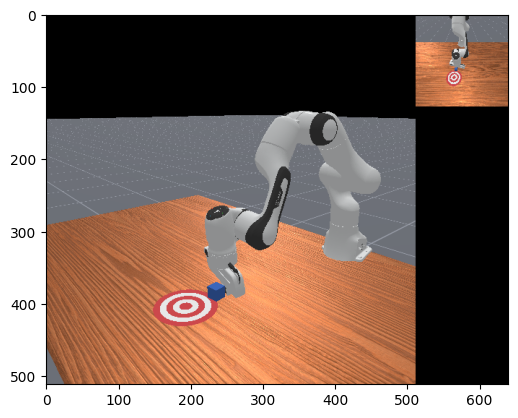

In [103]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.squeeze(frames[9]).detach().cpu().numpy())

In [14]:
eval_metrics

defaultdict(list,
            {'success_once': [tensor([True], device='cuda:0')],
             'return': [tensor([43.2704], device='cuda:0')],
             'episode_len': [tensor([50], device='cuda:0', dtype=torch.int32)],
             'reward': [tensor([0.8654], device='cuda:0')],
             'success_at_end': [tensor([True], device='cuda:0')]})

In [9]:
for k, v in eval_metrics.items():
    print(k)
    mean = torch.stack(v).float().mean()
    print(mean)
    # if logger is not None:
    #     logger.add_scalar(f"eval/{k}", mean, global_step)
    print(f"eval_{k}_mean={mean}")

# eval_success_once_mean=1.0
# eval_return_mean=42.43340301513672
# eval_episode_len_mean=50.0
# eval_reward_mean=0.8486680388450623
# eval_success_at_end_mean=1.0

success_once
tensor(0., device='cuda:0')
eval_success_once_mean=0.0
return
tensor(7.7800, device='cuda:0')
eval_return_mean=7.7799906730651855
episode_len
tensor(50., device='cuda:0')
eval_episode_len_mean=50.0
reward
tensor(0.1556, device='cuda:0')
eval_reward_mean=0.15559981763362885
success_at_end
tensor(0., device='cuda:0')
eval_success_at_end_mean=0.0


In [ ]:
# episode_info["reward"] = (episode_info["return"] / episode_info["episode_len"])

In [12]:
config['model_mode']


'RATE'

In [142]:
import os
import numpy as np
from tqdm import tqdm

npz_dir = "../ManiSkill/dataset_pushcube_v1_single_h5"
data_n = 1
data_sum = 0
data_sum_lst = []
for filename in tqdm(os.listdir(npz_dir)):
    if filename.endswith('.npz'):
        file_path = os.path.join(npz_dir, filename)
        with np.load(file_path, allow_pickle=False) as data:
            
            r = data['r'].copy()
            r[r != 1] = 0
        
            data_sum += r.sum()
            data_sum_lst.append(r.sum())
            data_n += 1

  0%|          | 0/8192 [00:00<?, ?it/s]

100%|██████████| 8192/8192 [00:07<00:00, 1155.44it/s]


In [143]:
data_sum / data_n

31.300012205541314

In [144]:
# Sort data_sum_lst in descending order
sorted_data = sorted(data_sum_lst, reverse=True)
print("Top 10 highest returns:", sorted_data[:10])
print("Mean:", np.mean(sorted_data[:10]))
print("Bottom 10 lowest returns:", sorted_data[-10:])


Top 10 highest returns: [43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 42.0, 42.0, 42.0, 42.0]
Mean: 42.6
Bottom 10 lowest returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
import numpy as np

file_path = "../ManiSkill/dataset_pushcube_v1_single_h5/trajectory_2.npz"
with np.load(file_path, allow_pickle=False) as data:
    rews = data['r'].copy()

In [30]:
rews[rews != 1] = 0

In [31]:
rews

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)